# Pet Segmentation

In this example, we will build an image segmentation model to segment
the 3 different classes in the [Oxford-IIIT Pet Segmentation
Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

We’ll use [Segmentation Models PyTorch]() which was introduced in an
earlier post on [Surface Defect
Segmentation](2022-06-30-surface-defect-segmentation.html), but in this
post we focus on
[Torchmetrics](https://torchmetrics.readthedocs.io/en/latest/), which is
a new library that has many metrics for classification/segmentation in
Pytorch. Torchmetrics

-   Allows for easy computation over batches.
-   Is rigorously tested.
-   A standardized interface to increase reproduciblity.
-   And much more…

Torchmetrics was already introduced for [Pet Breed
Classification](2022-08-17-pet_breed_classification.html), but in this
post we’ll describe the `mdmc_average` parameter which is relevant for
higher dimensional image data.

First we’ll install Torchmetrics with PyTorch Lightning below.

In [2]:
!pip install pytorch_lightning
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install watermark

In [3]:
import os
import random
import collections
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16

from pytorch_lightning import LightningModule, Trainer, seed_everything
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF
from torch.utils.data import random_split

seed_everything(7)

Global seed set to 7

7

## Exploratory Data Analysis

We’ll first look at some image/mask pairs in the dataset and basic
dataset statistics. To do this, we’ll resize the images to a standard
size of $224 \times 224$.

In [3]:
def transforms(image,target):
    image, target = TF.resize(image,(256,256)), TF.resize(target,(256,256))
    image, target = TF.center_crop(image,224), TF.center_crop(target, 224)
    # Shift the indicies so that they are from 0,...,num_classes-1
    return TF.to_tensor(image), 255*TF.to_tensor(target) - 1

In [4]:
# set download to False after the dataset is downloaded.
vis_dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="trainval", target_types="segmentation",transforms=transforms,download=True)

Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet
Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet

As we shall see below, the segmentation masks have 3 labels (see the
[Cats and
Dogs](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)
original paper):

1.  Pet Body
2.  Background
3.  Ambiguous region (between body and background)

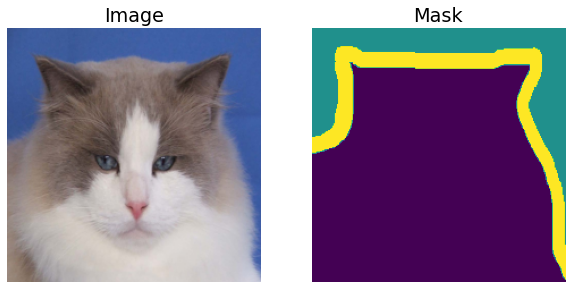

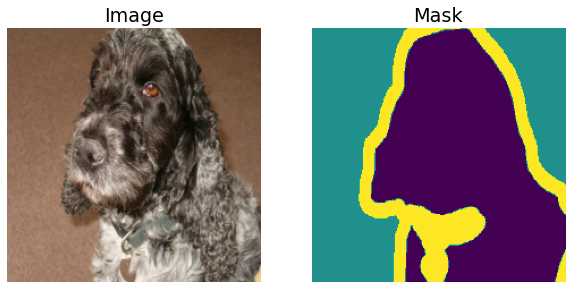

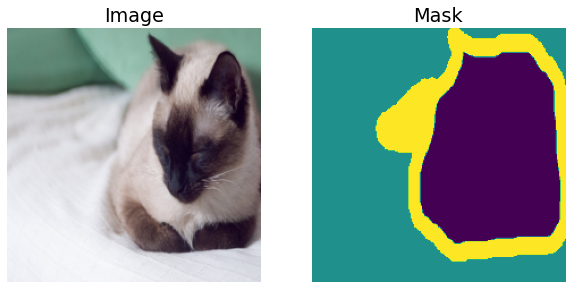

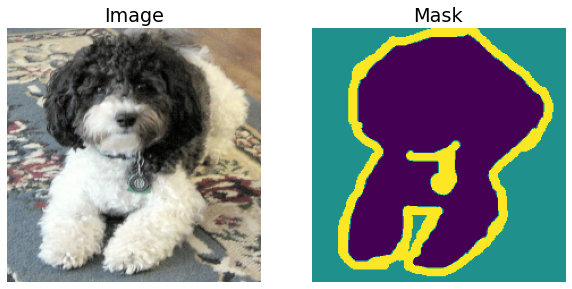

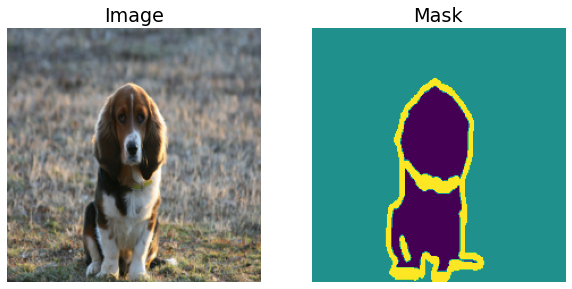

In [5]:
for i in range(5):
    sample_img, sample_msk = vis_dataset[random.choice(range(len(vis_dataset)))]
    plt.subplot(1,2,1)
    plt.title("Image")
    plt.axis("off")
    plt.imshow(sample_img.permute([1,2,0]))
    plt.subplot(1,2,2)
    plt.title("Mask")
    plt.axis("off")
    plt.imshow(sample_msk.permute([1,2,0]).squeeze())
    plt.show()

Now we’ll calculate the mask statistics.

In [6]:
# Use a dataloader to speed up the loading of masks.
vis_dataloader = torch.utils.data.DataLoader(vis_dataset, shuffle=False, batch_size=16, num_workers=os.cpu_count())
pixel_counts = collections.defaultdict(int)

for _, mask in vis_dataloader:
    labels, counts = np.unique(mask.numpy(),return_counts=True)
    labels = list(map(int, labels))
    
    for label, count in zip(labels,counts):
        pixel_counts[label] += count
        
# Work with normalized counts
pixel_counts = np.array(list(pixel_counts.values()))/sum(pixel_counts.values())

As the figure below shows, our dataset is mildly imbalanced. Thus as
mentioned in the [Surface Defect
Segmentation](2022-06-30-surface-defect-segmentation.html) post, it
makes sense to experiment with different loss functions offered by the
segmentation models library.

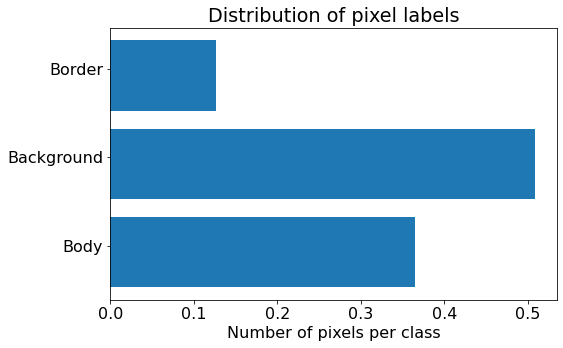

In [7]:
fig, ax = plt.subplots(figsize=(8,5))    
ax.barh(range(len(pixel_counts)), pixel_counts)
width=0.15
ind = np.arange(3)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(["Body", "Background", "Border"], minor=False)
plt.xlabel("Number of pixels per class")
plt.title("Distribution of pixel labels")
plt.show()

## Training

Define data augmentations to use with the train dataset. More data
augmentations are possible with the
[albumentations](https://albumentations.ai/) library.

In [14]:
def train_transforms(image,target):
    # Only horizontal flips
    if random.random() < 0.5:
        image = TF.hflip(image)
        target = TF.hflip(target)
        
    image, target = TF.resize(image,(256,256)), TF.resize(target,(256,256))
    image, target = TF.center_crop(image,224), TF.center_crop(target, 224)
    # Shift the indicies so that they are from 0,...,num_classes-1
    return TF.to_tensor(image), 255*TF.to_tensor(target) - 1

In [15]:
def val_transforms(image,target):
    image, target = TF.resize(image,(256,256)), TF.resize(target,(256,256))
    image, target = TF.center_crop(image,224), TF.center_crop(target, 224)
    # Shift the indicies so that they are from 0,...,num_classes-1
    return TF.to_tensor(image), 255*TF.to_tensor(target) - 1

In [16]:
# Set the download parameter to False after the datasets are downloaded.
train_dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="trainval", target_types="segmentation",transforms=train_transforms,download=False)
val_dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="test", target_types="segmentation",transforms=train_transforms,download=False)

In [17]:
print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(val_dataset))

Length of train dataset:  3680
Length of validation dataset:  3669

In [18]:
num_classes = 3
BATCH_SIZE = 16

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

Now we’ll subclass the LightningModule to create and train the model.
The code below is similar to that in [Pet Breed
Classification](2022-08-17-pet_breed_classification.html) and [Surface
Defect Segmentation](2022-06-30-surface-defect-segmentation.html), with
the main difference being the metrics we define below.

We’ll use the Accuracy and F1Score with `torchmetrics` to measure the
performance of our model. The main difference from the pet breed
classification example (which describes the `average` parameter) is that
now we have to use the `mdmc_average` parameter to reduce the extra
image dimensions, $H$ and $W$. We shall use `mdmc_average=global`, which
is described in greater detail below.

For a given batch of data of shape $[B, C,H,W]$, the option
`mdmc_average=global` collapses the data into shape
$[B\times H \times W, C]$ and then calculates the F1Score as for
multiclass classifiers. The option `mdmc_average=samplewise` on the
other hand calculates the F1score for each of the $B$ samples and each
of the $C$ classes, and then averages over the sample and class
dimensions
(cf. [F1Score](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html)).
The logic is similar for other metrics like the Dice score for example.
This will be elaborated in an upcoming post, giving comparisons with the
metrics in segmentation models pytorch, and recommendations for
practical usage.

In [20]:
import torch.nn as nn
from torchmetrics import MetricCollection, Accuracy, F1Score
from torch.nn import functional as F

class PetModel(LightningModule):
    
    def __init__(self, arch, encoder_name, learning_rate, num_classes, loss="DiceLoss", **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.zeros((BATCH_SIZE, 3, 224,224))
        
        # Setup the model.
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, encoder_weights = "imagenet", in_channels=3, classes=num_classes, **kwargs
        )
        
        # Setup the losses.
        if loss == "CrossEntropy":
            self.loss = nn.CrossEntropyLoss()
        else:
            self.loss = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
        
        # Setup the metrics.
        self.train_metrics = MetricCollection({"train_acc" : Accuracy(num_classes=num_classes, average="micro",mdmc_average="global"),
                                               "train_f1" : F1Score(num_classes=num_classes,average="weighted",mdmc_average="global")})
        self.val_metrics = MetricCollection({"val_acc" : Accuracy(num_classes=num_classes, average="micro",mdmc_average="global"),
                                               "val_f1" : F1Score(num_classes=num_classes,average="weighted",mdmc_average="global")})
        self.test_metrics = MetricCollection({"test_acc" : Accuracy(num_classes=num_classes, average="micro",mdmc_average="global"),
                                               "test_f1" : F1Score(num_classes=num_classes,average="weighted",mdmc_average="global")})
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, targets = batch
        #TODO: do this at dataset preparation.
        targets = targets.squeeze().long()
        
        logits_mask = self.forward(images)
        loss = self.loss(logits_mask, targets)
        preds = torch.softmax(logits_mask, dim=1)
        
        self.train_metrics(preds, targets)
        
        self.log("train_acc", self.train_metrics["train_acc"], prog_bar=True)
        self.log("train_f1", self.train_metrics["train_f1"], prog_bar=True)        
        self.log("train_loss", loss, prog_bar=True)        
        
        return loss
    
    def evaluate(self, batch, stage=None):
        images, targets = batch
        targets = targets.squeeze().long()
        
        logits_mask = self.forward(images)
        loss = self.loss(logits_mask, targets)
        preds = torch.softmax(logits_mask, dim=1)
        
        if stage == "val":
            self.val_metrics(preds,targets)
            
            self.log("val_acc", self.val_metrics["val_acc"], prog_bar=True)
            self.log("val_f1", self.val_metrics["val_f1"], prog_bar=True)        
            self.log("val_loss", loss, prog_bar=True)  
        elif stage == "test":
            self.test_metrics(preds,targets)
            
            self.log("test_acc", self.test_metrics["test_acc"], prog_bar=True)
            self.log("test_f1", self.test_metrics["test_f1"], prog_bar=True)        
            self.log("test_loss", loss, prog_bar=True)  
            
    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self.evaluate(batch, "test")
    
    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=self.hparams.learning_rate)

We’ll start off with the UNET architecture using a resnet34 backbone.
Other options include using the DeepLabV3 architecture and the RegNetX
backbone for slightly higher accuracy.

In [21]:
model = PetModel("UNET", "resnet34", 1e-3, num_classes, loss="CrossEntropy")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth

We’ll log metrics to TensorBoard using the `TensorBoardLogger`, and save
the best model, measured using F1Score, with the `ModelCheckpoint`. Note
that we use the F1Score instead of Accuracy because of the mild class
imbalance.

In [22]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

name = "oxfordpet" + "_" + model.hparams.arch + "_" + model.hparams.encoder_name + "_" + model.hparams.loss
logger = TensorBoardLogger(save_dir="lightning_logs",
                           name=name,
                           log_graph=True,
                           default_hp_metric=False)
callbacks = [ModelCheckpoint(monitor="val_f1",save_top_k=1, mode="max") ]

In [23]:
from itertools import islice

def show_predictions_from_batch(model, dataloader, batch_num=0, limit = None):
    """
        Method to visualize model predictions from batch batch_num.
        
        Show a maximum of limit images.
    """
    batch = next(islice(iter(dataloader), batch_num, None), None) # Selects the nth item from dataloader, returning None if not possible.
    images, masks = batch

    with torch.no_grad():
        model.eval()

        logits = model(images)

    pr_masks = torch.argmax(logits,dim=1)

    for i, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
        if limit and i == limit:
            break
        fig = plt.figure(figsize=(15,4))

        ax = fig.add_subplot(1,3,1)
        ax.imshow(image.squeeze().permute([1,2,0]))
        ax.set_title("Image")
        ax.axis("off")

        ax = fig.add_subplot(1,3,2)
        ax.imshow(gt_mask.squeeze())
        ax.set_title("Ground truth")
        ax.axis("off")

        ax = fig.add_subplot(1,3,3)
        ax.imshow(pr_mask.squeeze())
        ax.set_title("Predicted mask")
        ax.axis("off")

Sanity check the model by showing its predictions.

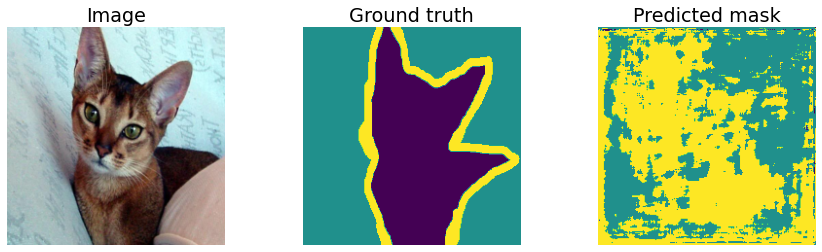

In [24]:
show_predictions_from_batch(model, val_dataloader, batch_num=3, limit=1)

Visualize training progress in TesnorBoard.

In [25]:
%load_ext tensorboard
%tensorboard --logdir=./lightning_logs --bind_all

In [27]:
trainer = Trainer(accelerator='gpu',
                  devices=1,
                  max_epochs=12,
                  logger=logger,
                  callbacks=callbacks,
                  fast_dev_run=False)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs

Finally, fit the model on the training dataset while saving the best
model based on performance on the validation dataset.

In [28]:
trainer.fit(model, 
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | In sizes          | Out sizes        
-------------------------------------------------------------------------------------------
0 | model         | Unet             | 24.4 M | [16, 3, 224, 224] | [16, 3, 224, 224]
1 | loss          | CrossEntropyLoss | 0      | ?                 | ?                
2 | train_metrics | MetricCollection | 0      | ?                 | ?                
3 | val_metrics   | MetricCollection | 0      | ?                 | ?                
4 | test_metrics  | MetricCollection | 0      | ?                 | ?                
-------------------------------------------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.747    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/

Visualize the model performance on the validation set.

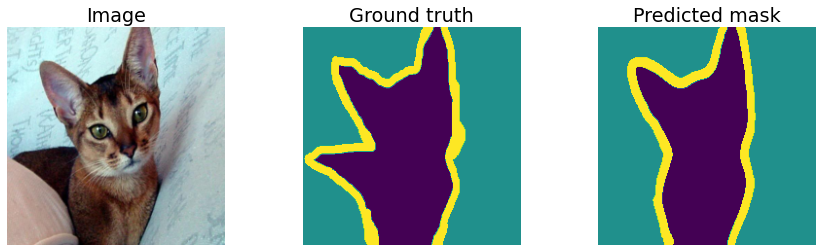

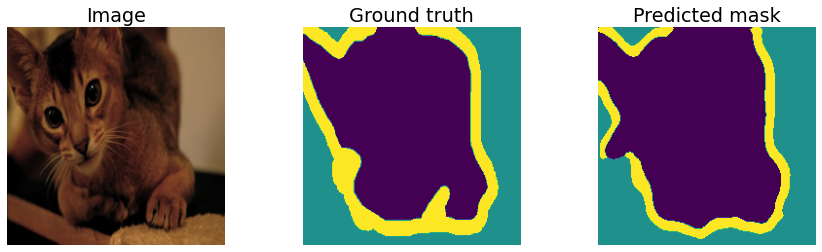

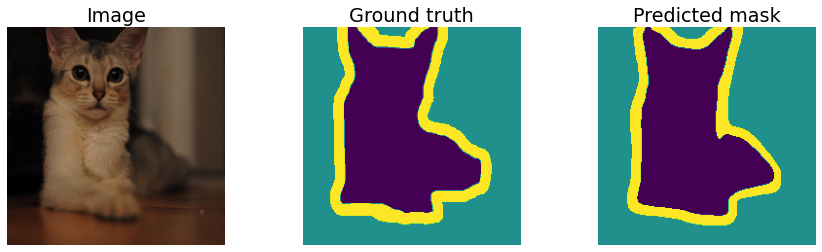

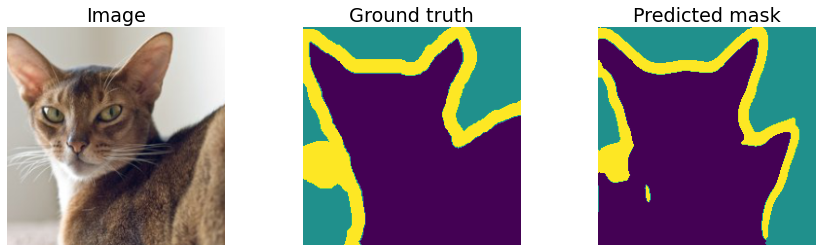

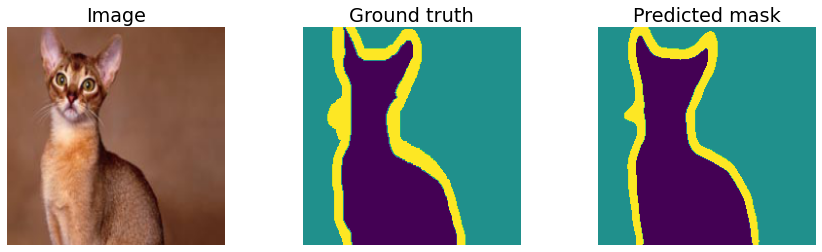

In [29]:
show_predictions_from_batch(model, val_dataloader, batch_num=3, limit=5)

## Analyze best saved model on the Validation dataset

In [30]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)

lightning_logs/oxfordpet_UNET_resnet34_CrossEntropy/version_0/checkpoints/epoch=10-step=2530.ckpt

In [31]:
best_model = PetModel.load_from_checkpoint(checkpoint_path=best_model_path)

In [32]:
trainer.test(best_model,dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8975881338119507
         test_f1             0.896770715713501
        test_loss           0.27673694491386414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[{'test_acc': 0.8975881338119507,
  'test_f1': 0.896770715713501,
  'test_loss': 0.27673694491386414}]

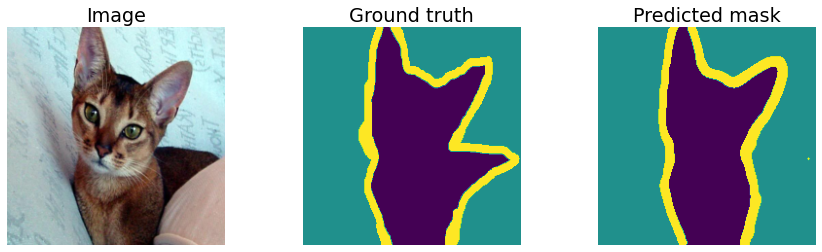

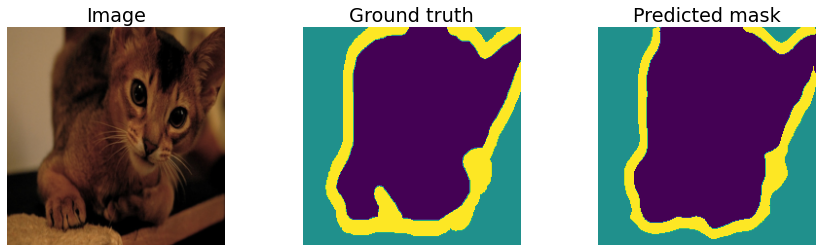

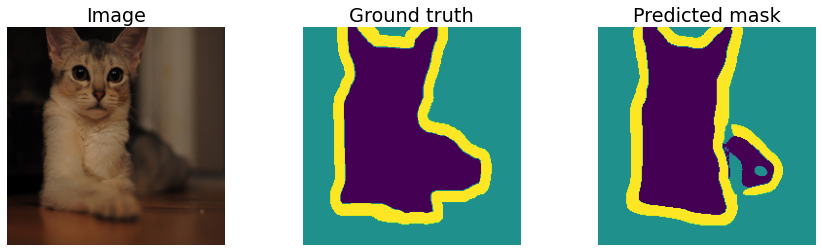

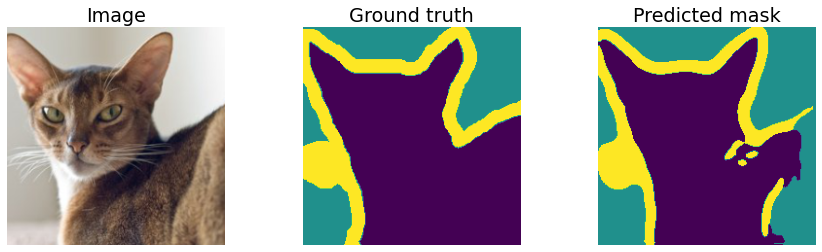

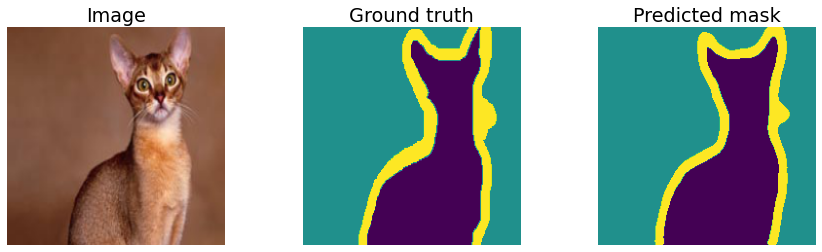

In [33]:
show_predictions_from_batch(best_model, val_dataloader, batch_num=3, limit=5)

In [4]:
%load_ext watermark
%watermark --iversions -v

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.31.0

segmentation_models_pytorch: 0.3.0
matplotlib                 : 3.5.1
torchvision                : 0.13.0
torch                      : 1.12.0
numpy                      : 1.19.5
